# pySCENIC protocol: lenti-DLX2 cells only

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
print(sys.executable)
print(sys.path)
print(sys.version)

/home2/s418610/.conda/envs/py37_res_GRN/bin/python
['/home2/s418610/jupyter_notebooks/03.Invivo_neuronal_reprogramming/12.GRN_analysis/PO_v2', '', '/cm/shared/apps/cnvkit/0.9.5/lib/python3.6/site-packages', '/cm/shared/apps/python/3.6.4-anaconda/lib', '/cm/shared/apps/jupyterkernel-matlab/0.16.1/lib/python3.6/site-packages', '/cm/shared/apps/python/2.7.x-anaconda/lib', '/home2/s418610/.conda/envs/py37_res_GRN/lib/python37.zip', '/home2/s418610/.conda/envs/py37_res_GRN/lib/python3.7', '/home2/s418610/.conda/envs/py37_res_GRN/lib/python3.7/lib-dynload', '/home2/s418610/.local/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_GRN/lib/python3.7/site-packages', '/home2/s418610/.conda/envs/py37_res_GRN/lib/python3.7/site-packages/fa2-0.3.5-py3.7-linux-x86_64.egg', '/home2/s418610/.conda/envs/py37_res_GRN/lib/python3.7/site-packages/matplotlib_venn-0.11.5-py3.7.egg', '/home2/s418610/.conda/envs/py37_res_GRN/lib/python3.7/site-packages/IPython/extensions', '/home2/s418610/.ipy

In [3]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/17.POv2_SCENIC_analysis/"
os.chdir( wdir )

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "POv2_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "POv2_pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'POv2_scenic_integrated-output.loom'

In [4]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

scanpy==1.4.5.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [5]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 20

## 1. Expression data import


### Reading in expression data: 10x Genomics mtx files

#### Read filtered read count matrix

In [10]:
data_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/PipelineOrganized_v1/'

adata = sc.read(data_dir + 'POv2_BL41-42_10X-samples11_51_postFiltering.h5ad') 

#### Read lenti-DLX2 neural sub-dataset

In [11]:
neural_data_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/PipelineOrganized_v1/NeuralOnly/'

adata_neural = sc.read(neural_data_dir + 'POv2_BL41Only_NeuronalOnly_postFiltering_log_pcs50_Harmony_louvain_anno_pseudotime.h5ad')

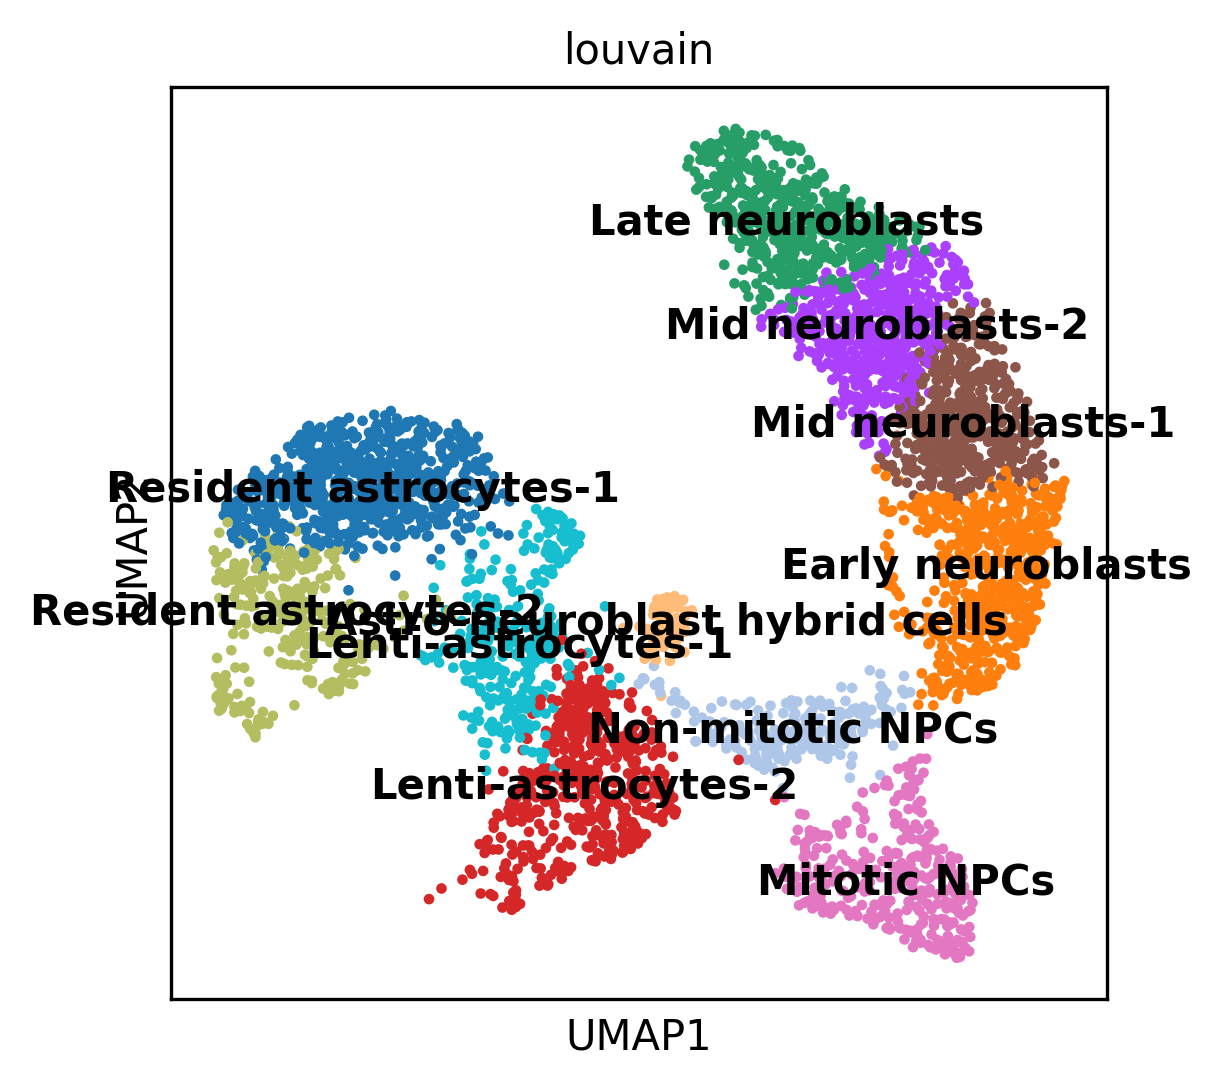

In [15]:
sc.pl.umap(adata_neural, color='louvain', legend_loc='on data')

#### Slice filtered read count matrix by lenti-DLX2 group cell IDs

In [17]:
adata = adata[adata_neural.obs.index,:]

In [18]:
adata

View of AnnData object with n_obs × n_vars = 4601 × 20004 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'library_name_colors'

In [19]:
adata.var_names_make_unique()

## 2. Initial/basic filtering

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  902934.0
Number of cells in which each gene is detected: 0  -  4601


In [22]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  138.03
minSamples:  46.01


In [23]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

Trying to set attribute `.obs` of view, making a copy.


### Diagnostic plots, pre-filtering

#### Number of genes expressed per cell

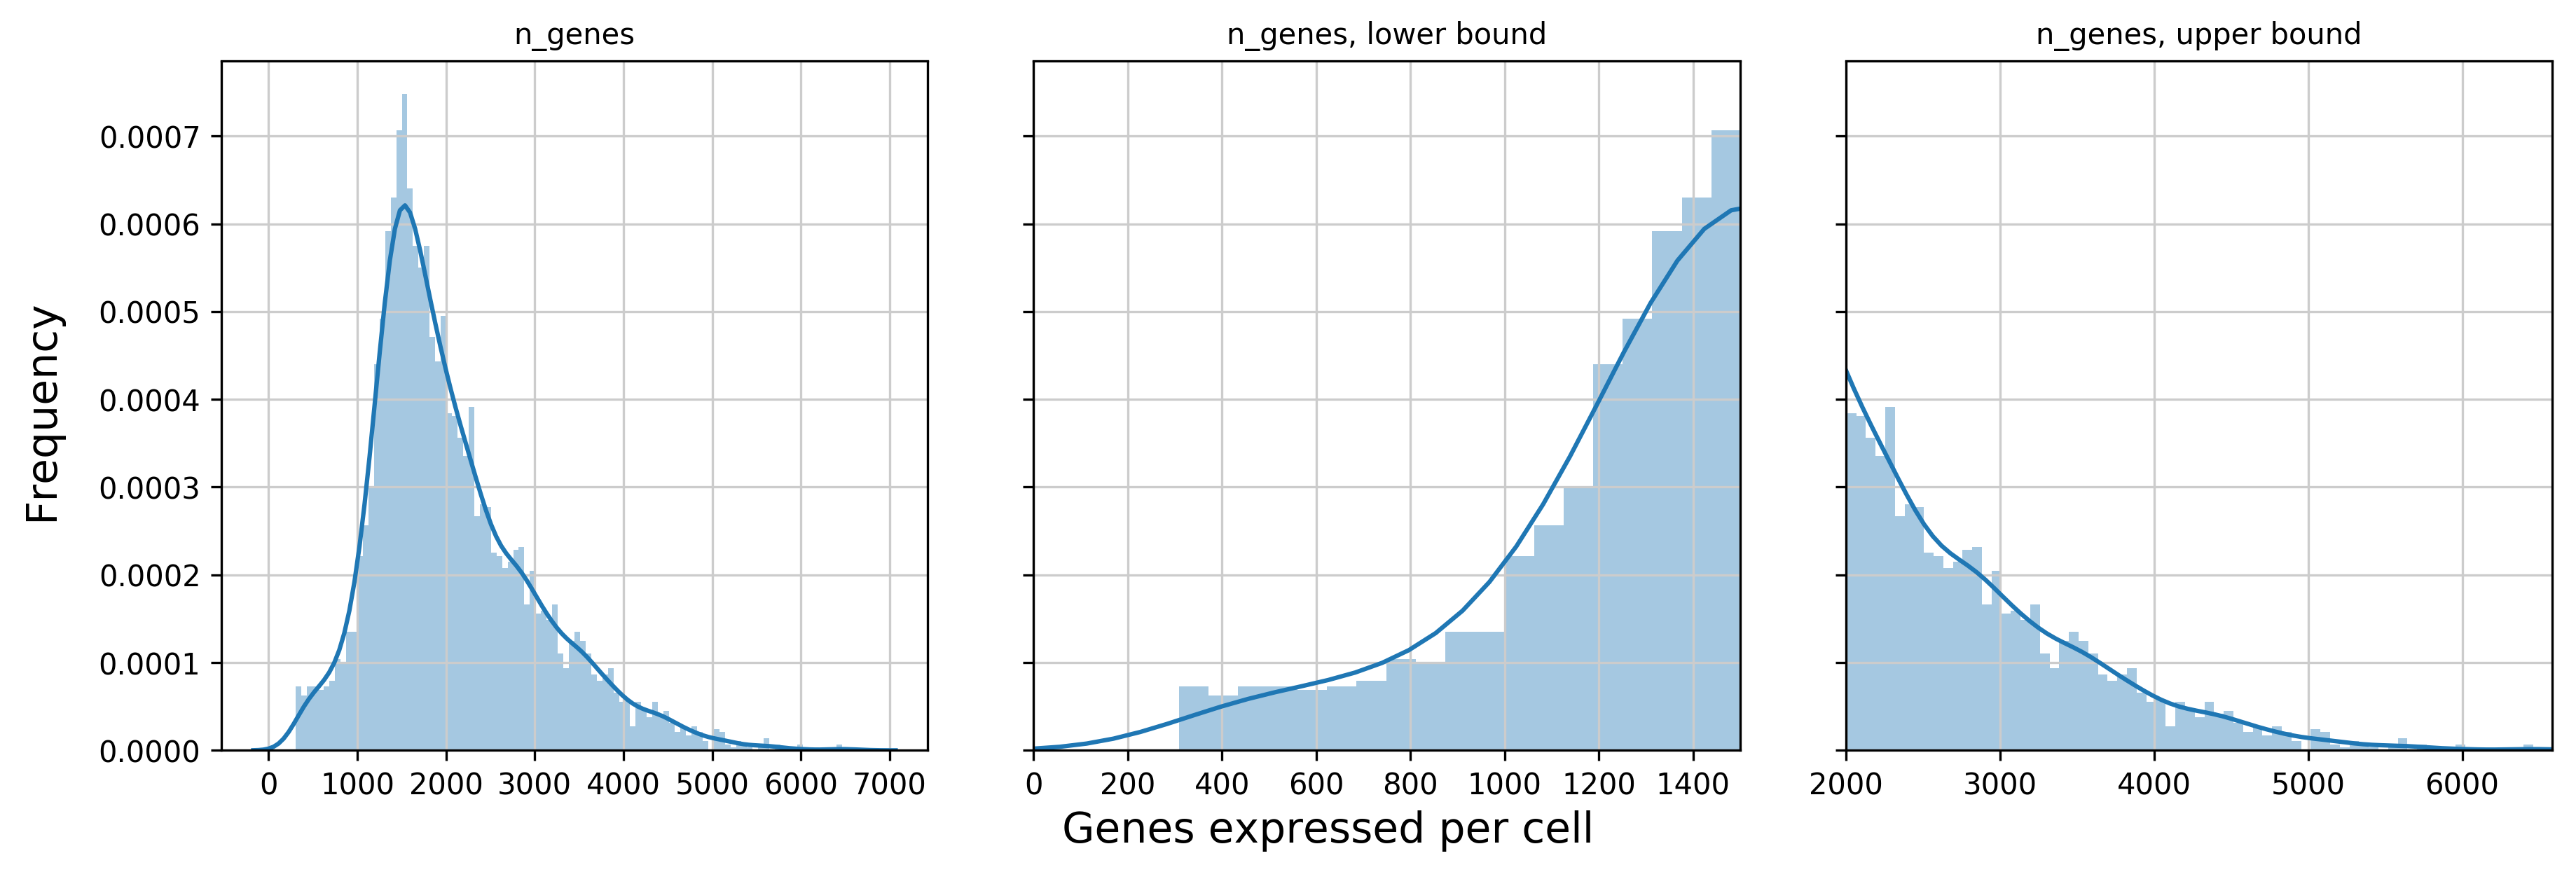

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

#### Percentage of mitochondrial reads per cell

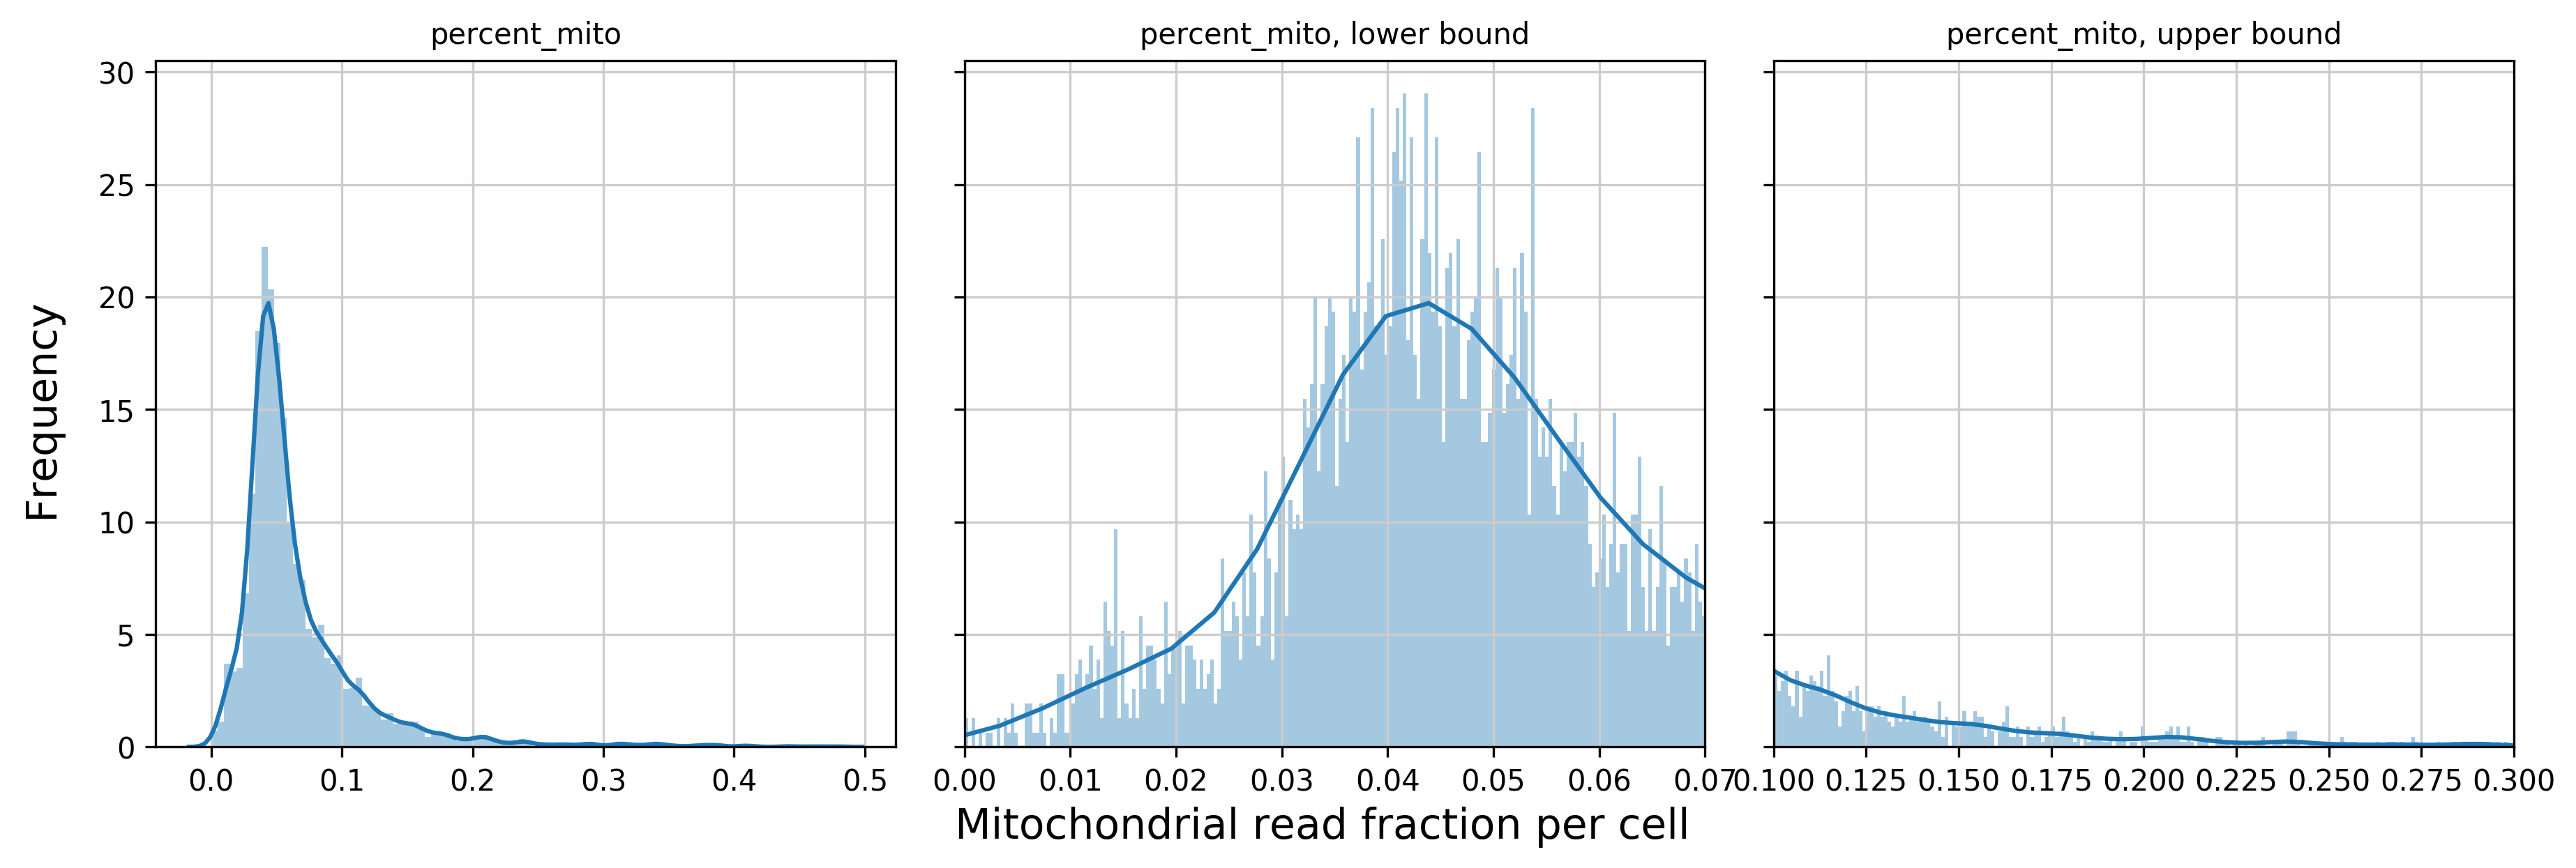

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

#### Three-panel summary plots

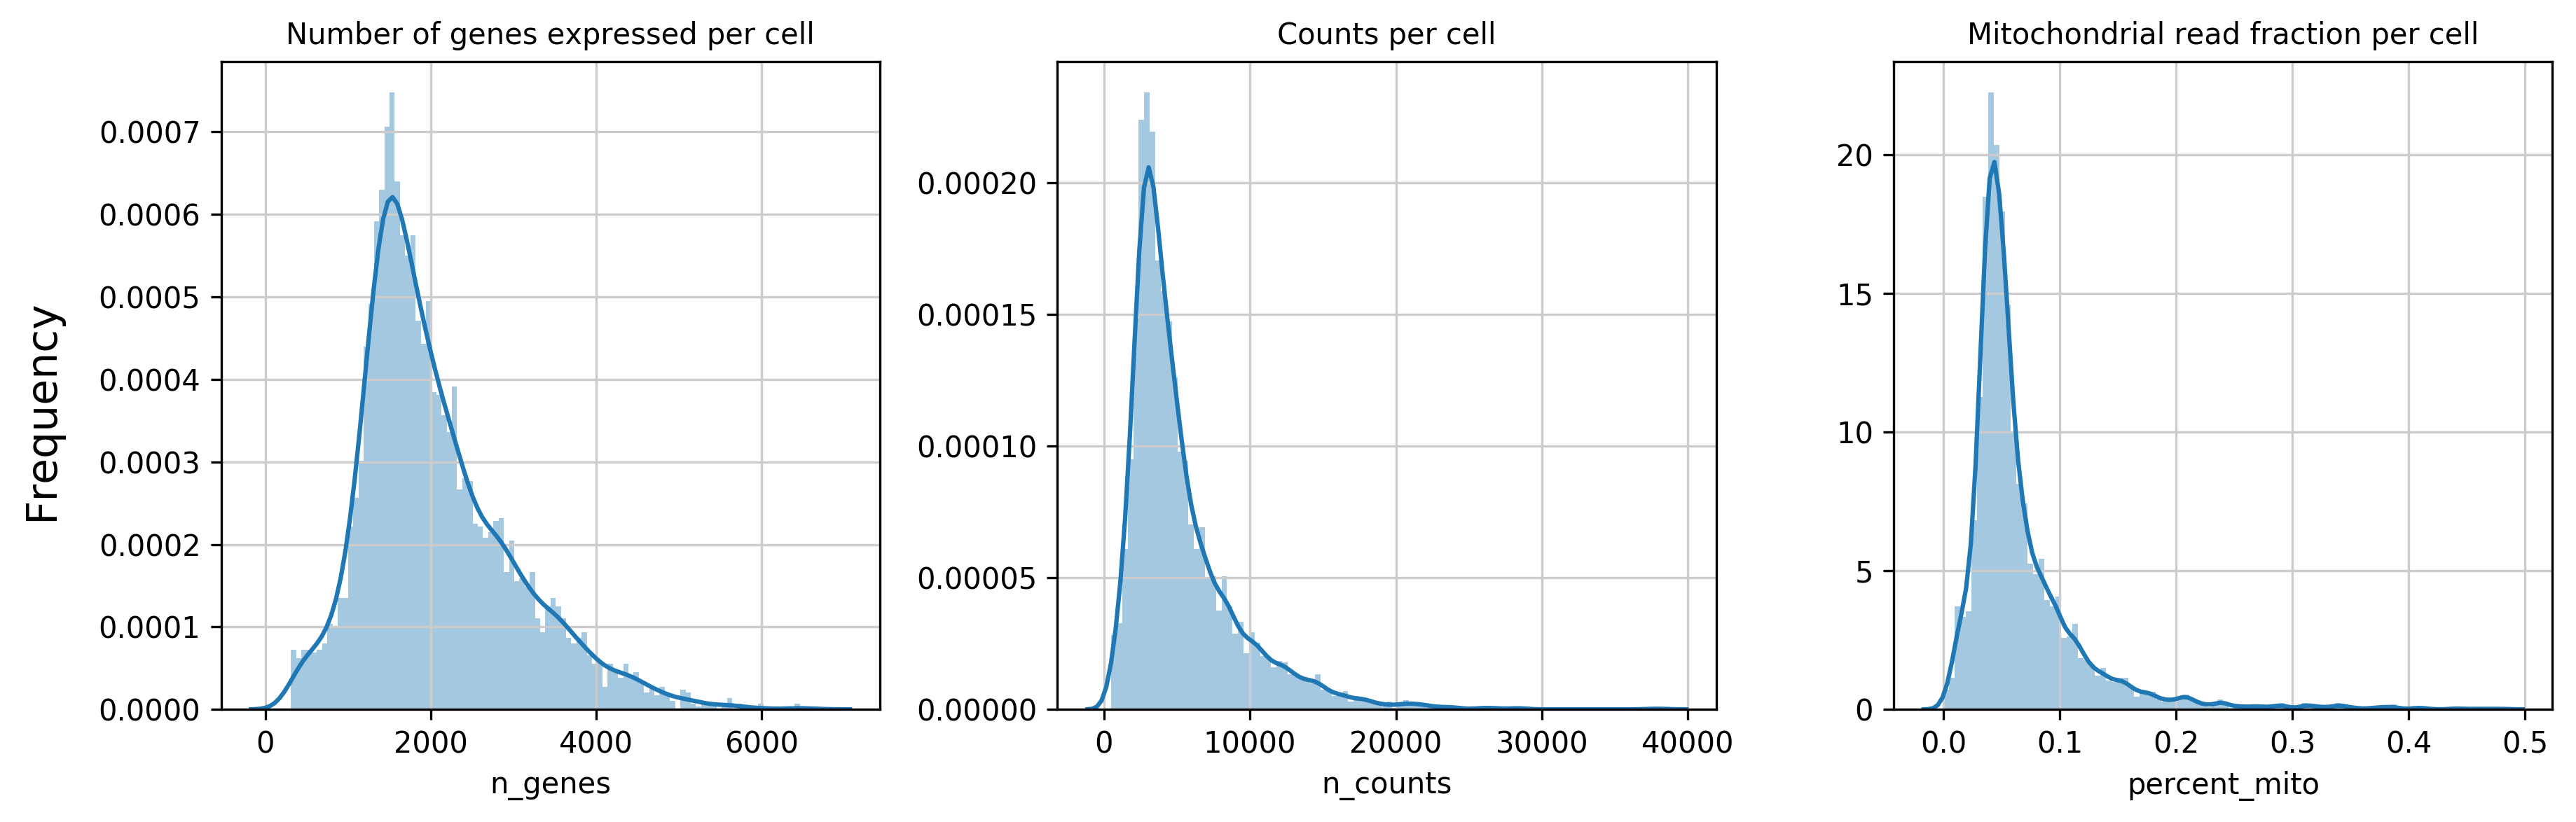

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

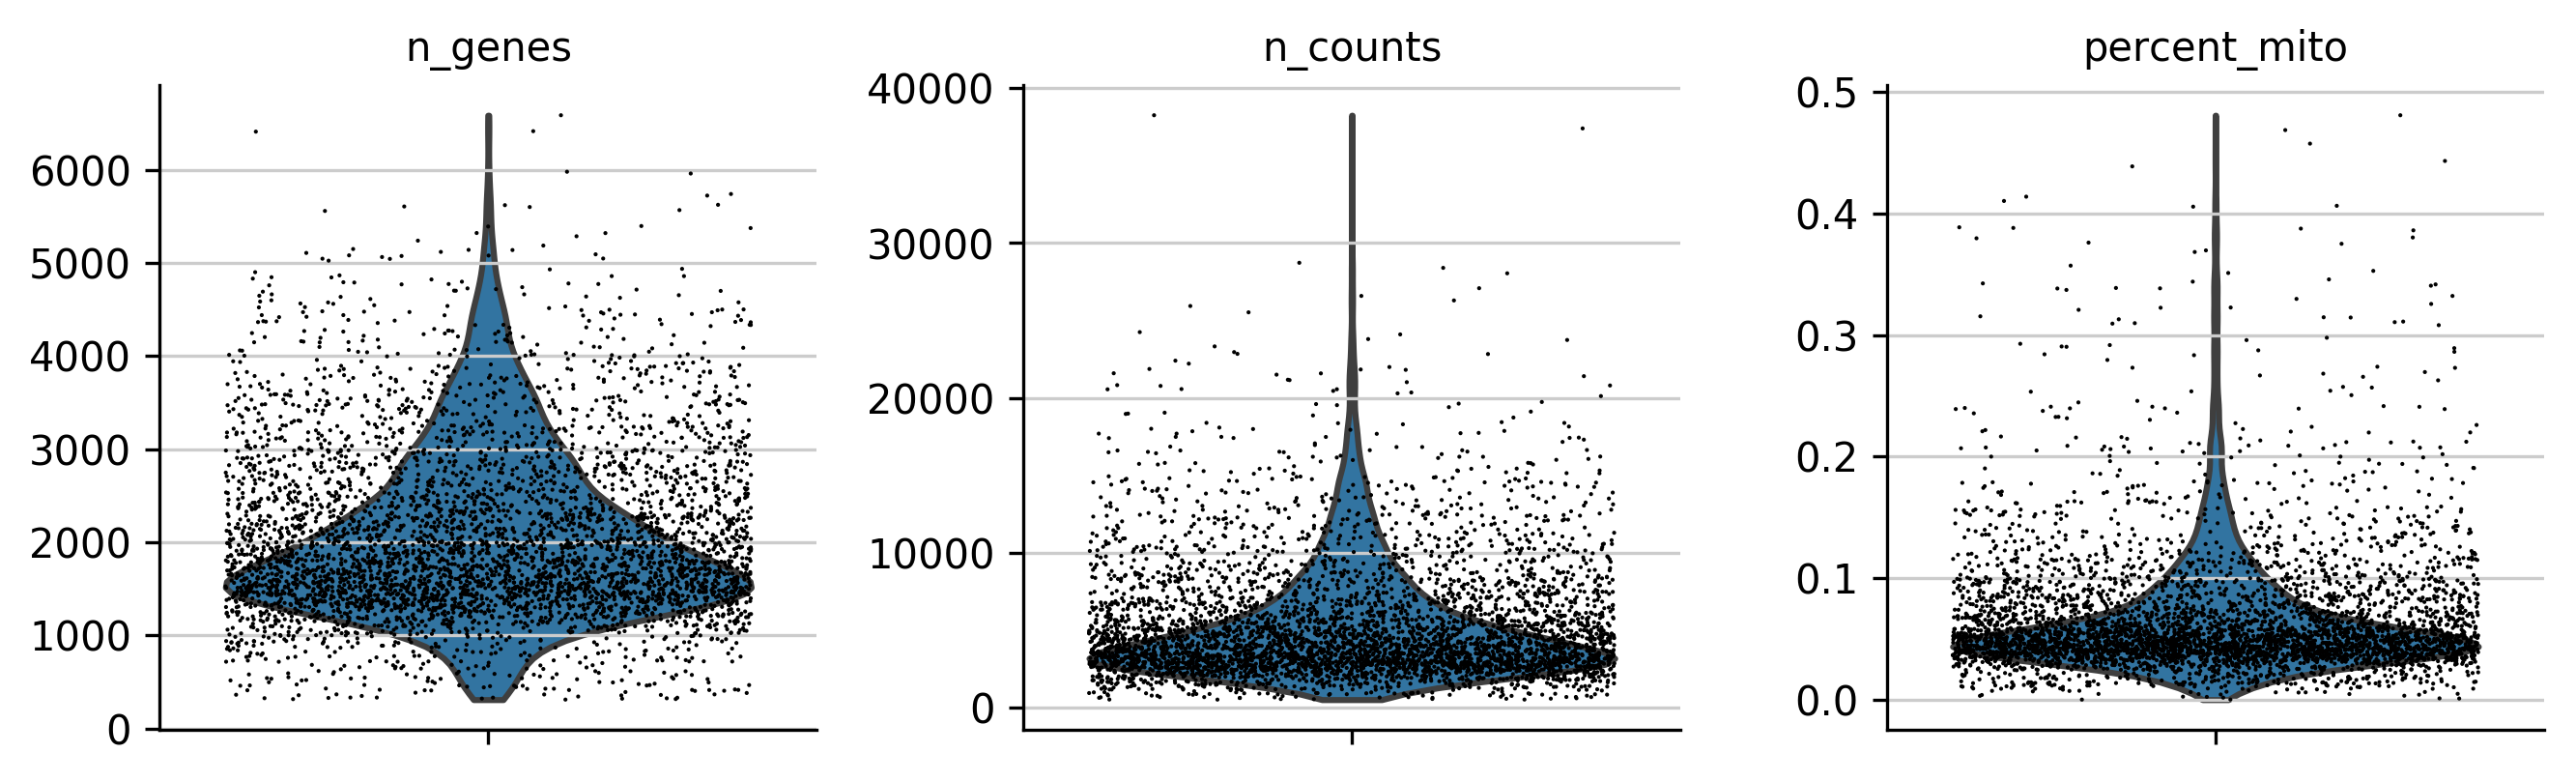

In [27]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

#### Scatter plot, n_genes by n_counts

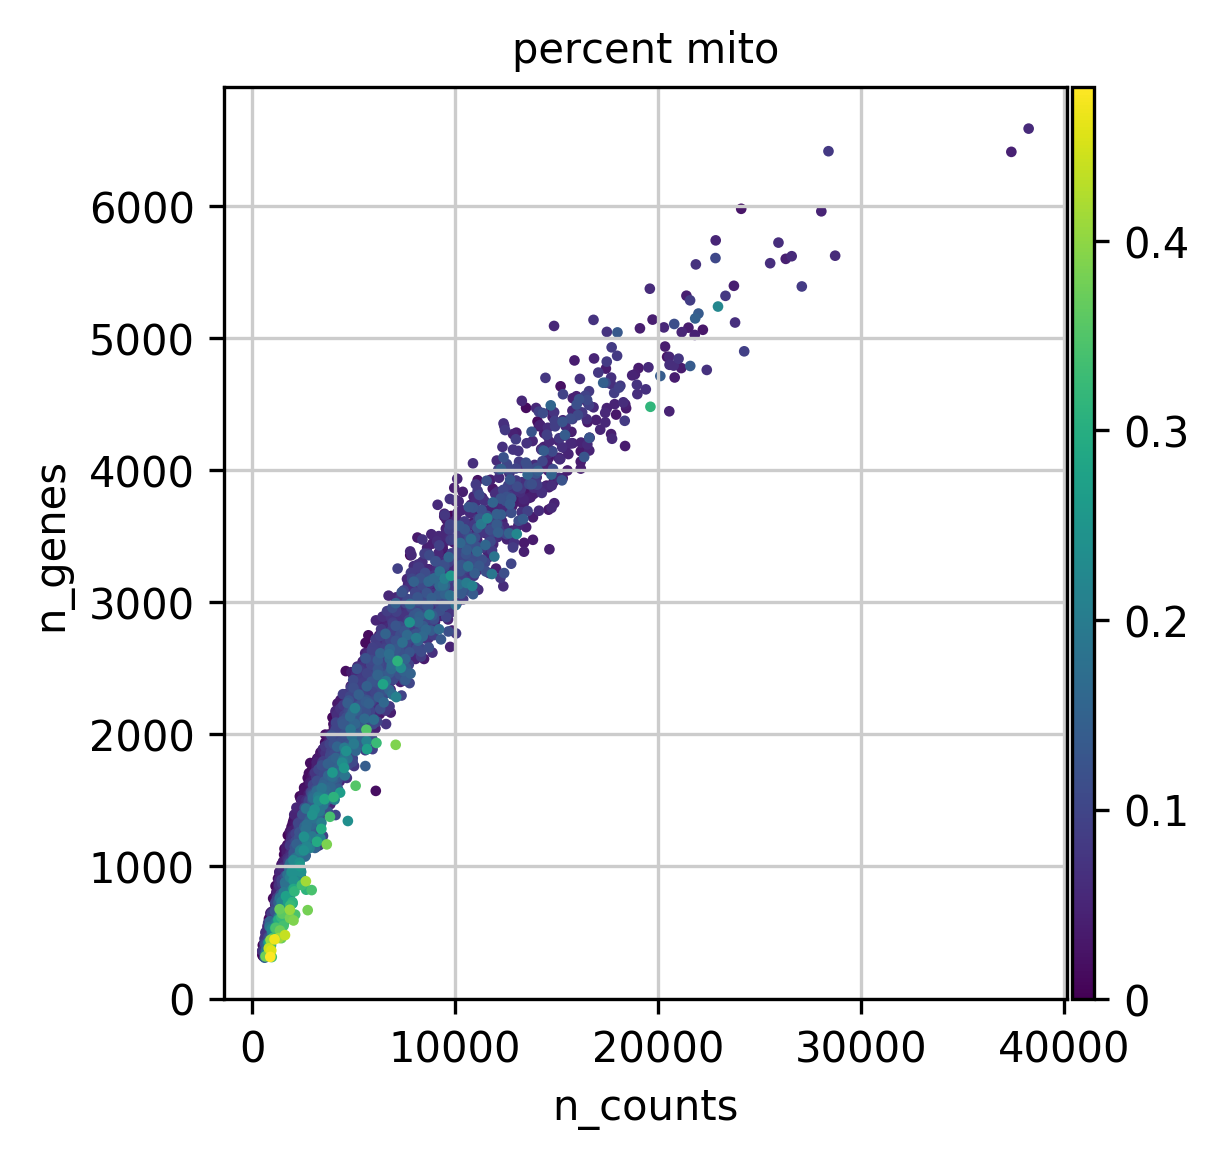

In [28]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

### Carry out the filtering steps:

In [ ]:
#### Since the loaded read count matrix has been already filtered, there's no need to filter cells again

In [29]:
# sc.pp.filter_cells(adata, min_genes=100 )
sc.pp.filter_genes(adata, min_cells=5 )

filtered out 3994 genes that are detected in less than 5 cells


In [30]:
# adata = adata[adata.obs['n_genes'] < 8000, :]
# adata = adata[adata.obs['percent_mito'] < 1, :]

In [31]:
adata

View of AnnData object with n_obs × n_vars = 4601 × 16010 
    obs: 'library_name', 'batch', 'lenti_count', 'lenti_log1p_count', 'tdT_count', 'tdT_log1p_count', 'n_counts', 'log_counts', 'n_genes', 'mt_count', 'mt_frac', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'library_name_colors'

### Diagnostic plots, post filtering

#### Three-panel summary plots

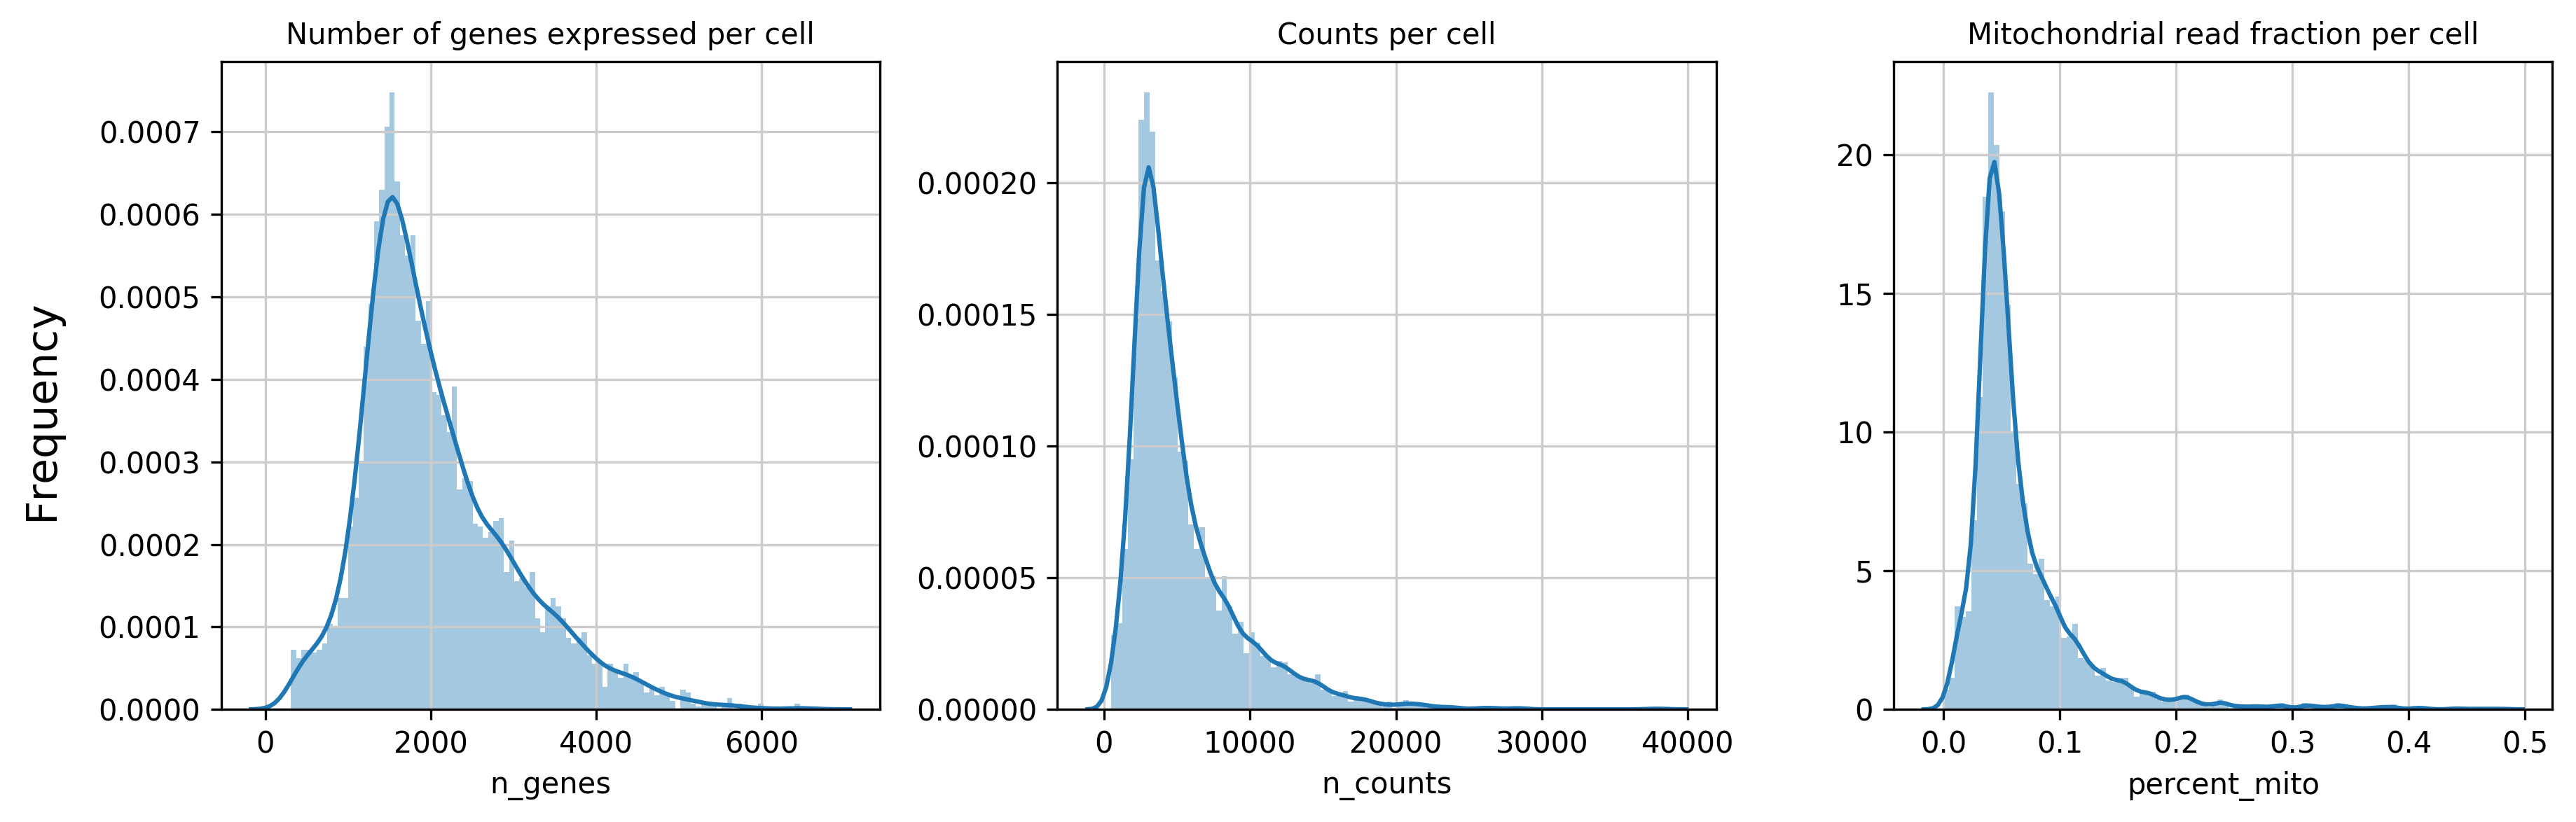

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

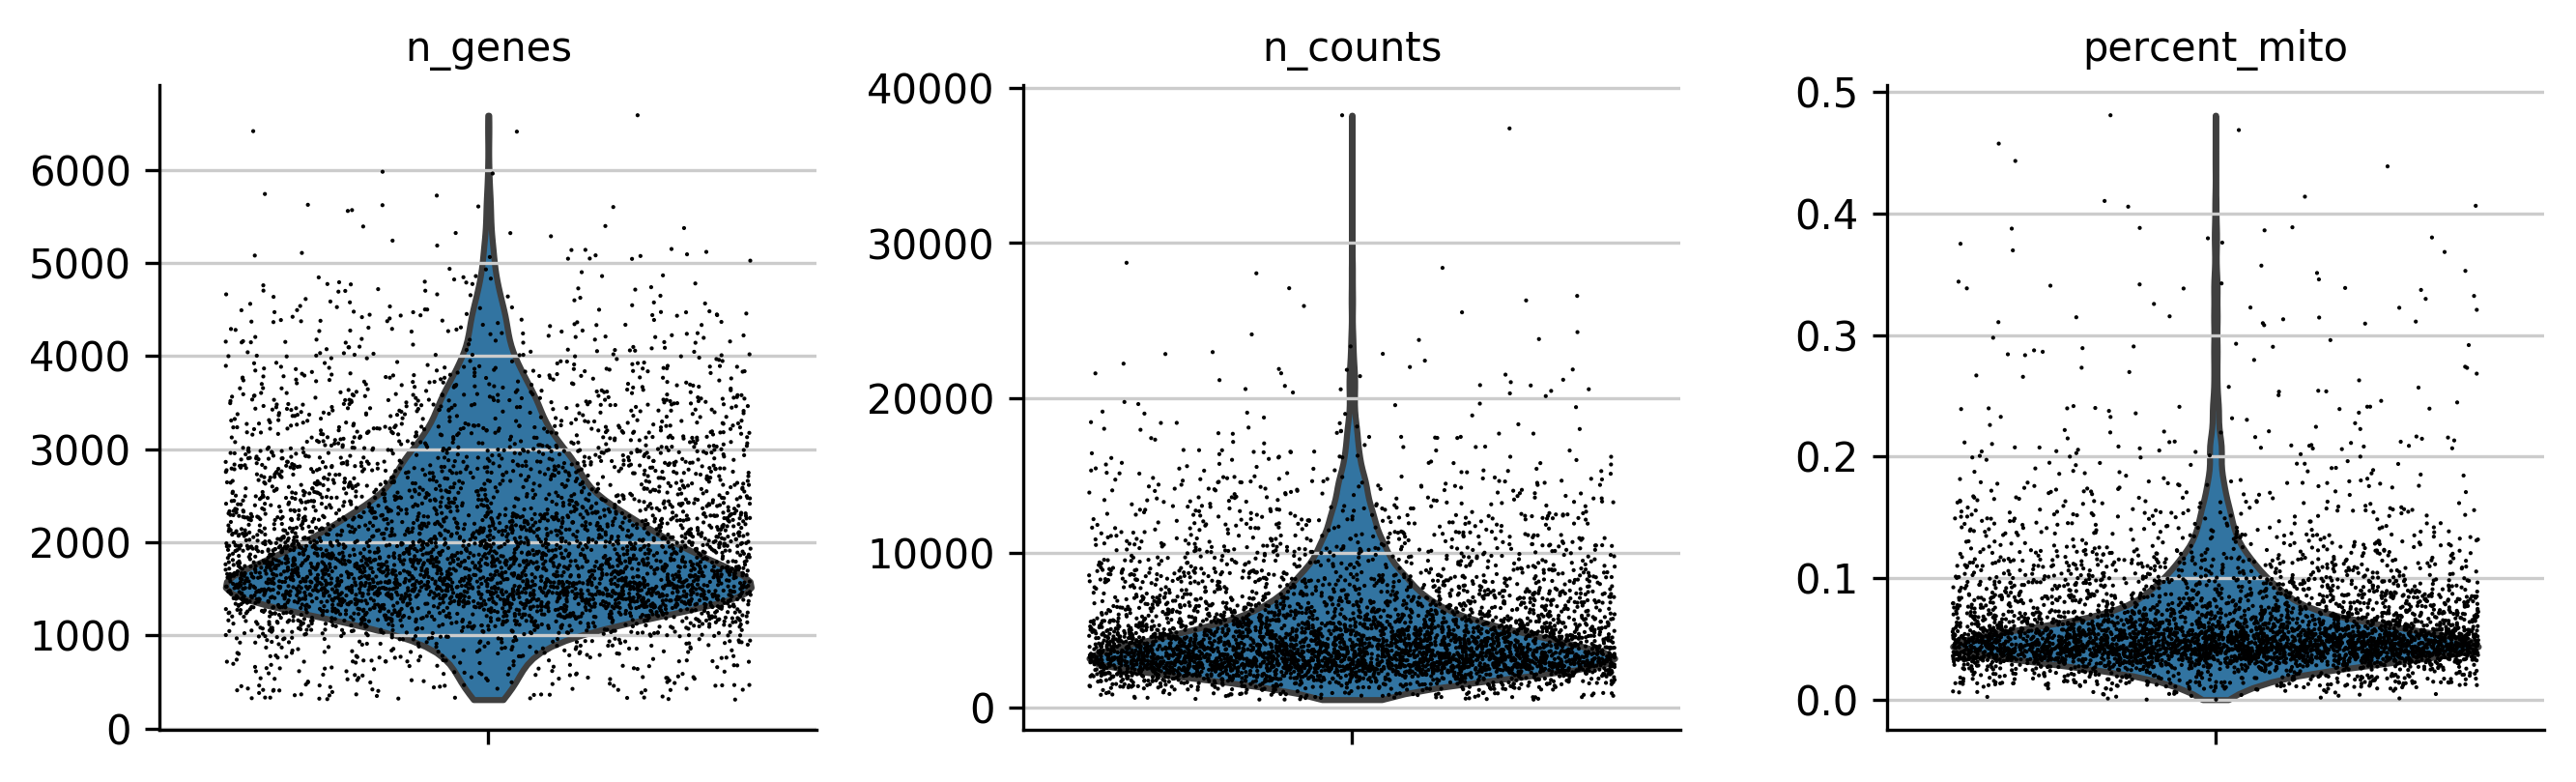

In [33]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

#### Scatter plot, n_genes by n_counts

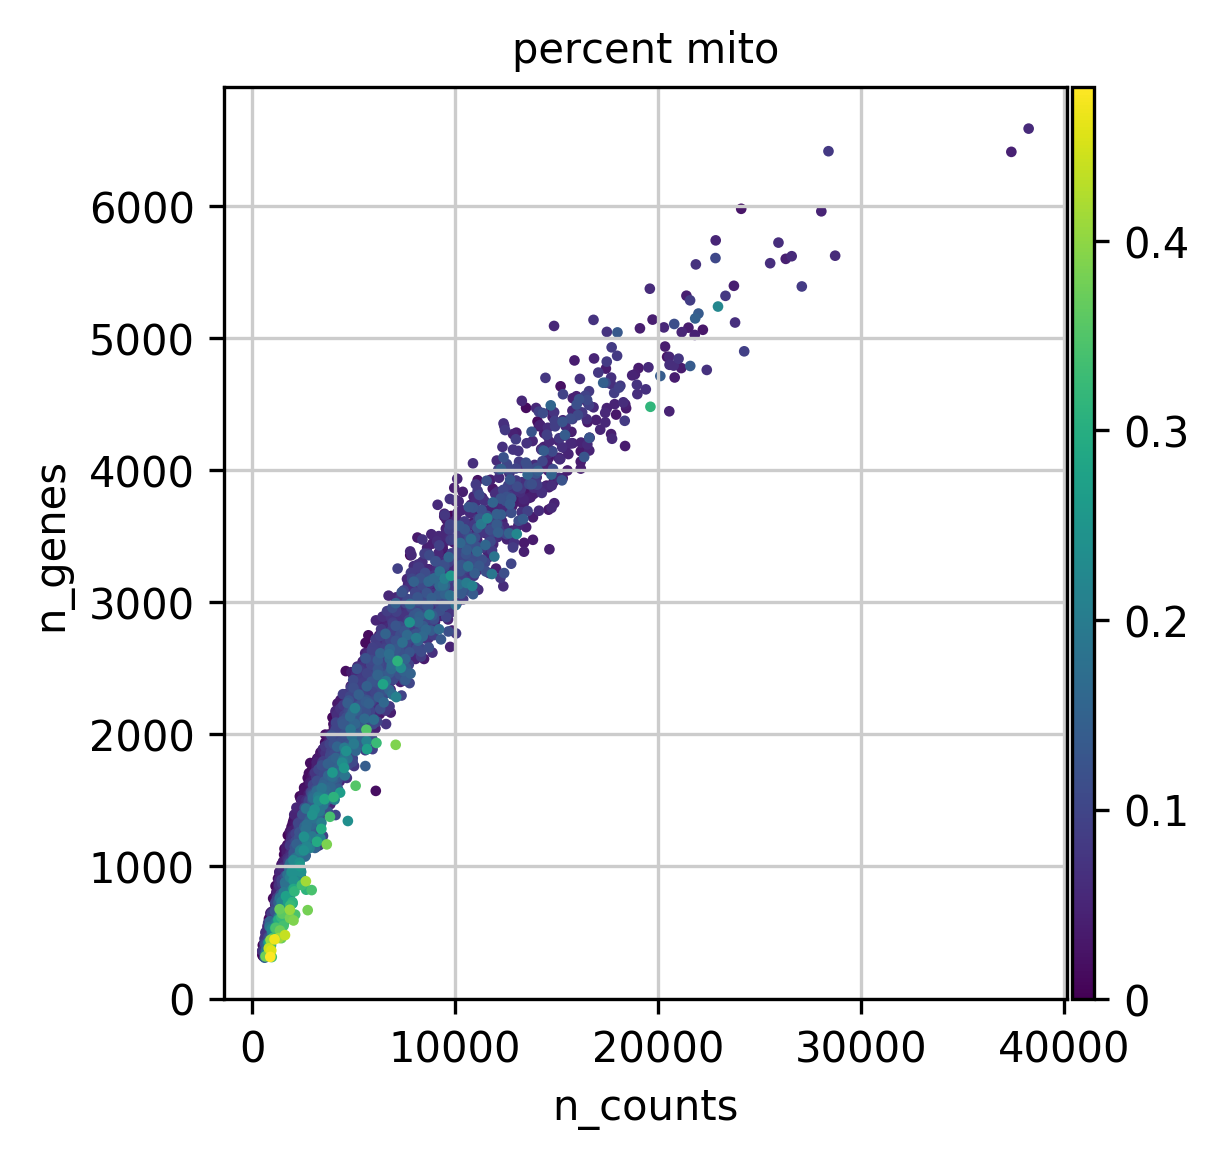

In [34]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

### Finalize the selected filters

Update the anndata file, to be used for further processing, clustering, visualization, etc..

In [35]:
adata.write( f_anndata_path )

Output the basic filtered expression matrix to a loom file.  

This can also be used in the command-line pySCENIC steps, for example, or as an input to the Nextflow pipeline.

In [36]:
assert sum(adata.obs.index == adata_neural.obs.index) == 4601

In [37]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
    "rank_pseudotime": adata_neural.obs['rank_pseudotime'].tolist(), 
    "library_name": adata_neural.obs['library_name'].tolist(), 
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

## 3. SCENIC steps

### STEP 1: Gene regulatory network inference, and generation of co-expression modules
#### Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier.
_Output:_ List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

In [38]:
# transcription factors list
#f_tfs = "/project/GCRB/Hon_lab/s418610/Projects/98.Exercises/01.SCENIC_example/10X_PBMC/resources/allTFs_hg38.txt" # human
# f_tfs = "/ddn1/vol1/staging/leuven/stg_00002/lcb/cflerin/resources/allTFs_dmel.txt" # drosophila
f_tfs = "/project/GCRB/Hon_lab/s418610/Projects/98.Exercises/01.SCENIC_example/10X_PBMC/resources/allTFs_mm.txt"   # mouse
# tf_names = load_tf_names( f_tfs )

In [39]:
arboreto_with_multiprocessing = '/project/GCRB/Hon_lab/s418610/Projects/98.Exercises/01.SCENIC_example/SCENICprotocol/bin/arboreto_with_multiprocessing.py'

In [40]:
!/home2/s418610/.conda/envs/py37_res_GRN/bin/python {arboreto_with_multiprocessing} \
    {f_loom_path_scenic} \
    {f_tfs} \
    --method grnboost2 \
    --output adj.tsv \
    --num_workers 20 \
    --seed 777

Loaded expression matrix of 4601 cells and 16010 genes in 1.0210812091827393 seconds...
Loaded 1721 TFs...
/home2/s418610/.conda/envs/py37_res_GRN/lib/python3.7/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()
starting grnboost2 using 20 processes...
100%|█████████████████████████████████████| 16010/16010 [37:05<00:00,  7.19it/s]
Done in 2232.3509559631348 seconds.


read in the adjacencies matrix:

In [41]:
adjacencies = pd.read_csv("adj.tsv", index_col=False, sep='\t')

In [42]:
adjacencies.head()

,TF,target,importance
0,Sox4,Gm26735,137.597499
1,Rps4x,Tpt1,132.123390
2,Rps4x,Rpl7,130.633308
3,Rps4x,Rpl13,128.137715
4,Rps4x,Rps9,124.632417


### STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. **Script is included for using Singularity image of pySCENIC to run this step. **

This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `MOTIFS_FNAME`.

### STEP 4: Cellular enrichment (aka AUCell) from CLI

In [6]:
!/home2/s418610/.conda/envs/py37_res_GRN/bin/pyscenic aucell \
    {f_loom_path_scenic} \
    regulons.csv \
    --output {f_pyscenic_output} \
    --num_workers 20


2020-08-06 10:33:47,968 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2020-08-06 10:33:49,940 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2020-08-06 10:34:33,076 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2020-08-06 10:34:50,268 - pyscenic.cli.pyscenic - INFO - Writing results to file.


### Visualization of SCENIC's AUC matrix

In [7]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [8]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

/home2/s418610/.conda/envs/py37_res_GRN/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../home2/s418610/.conda/envs/py37_res_GRN/lib/python3.7/site-packages/umap/utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
/home2/s418610/.conda/envs/py37_res_GRN/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-do

## 4. Integrate the output

In [9]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [10]:
exprMat.shape

(16010, 4601)

Fix regulon objects to display properly in SCope:

In [11]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

Concatenate embeddings (tSNE, UMAP, etc.)

In [12]:
adata = sc.read_h5ad( f_anndata_path )

In [13]:
neural_data_dir = '/project/GCRB/Hon_lab/s418610/Projects/03.Invivo_neuronal_reprogramming/analysis/Cluster_with_10X_20k/data/10x_remapped/PipelineOrganized_v1/NeuralOnly/'

In [14]:
adata_neural = sc.read(neural_data_dir + 'BL41Only_NeuronalOnly_postFiltering_log_pcs50_Harmony_louvain_anno_pseudotime.h5ad')

In [15]:
adata = adata_neural.copy()

In [16]:
# tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

Metadata:

In [17]:
### metadata
metaJson = {}

metaJson['embeddings'] = [
#    {
#        "id": -1,
#        "name": f"Scanpy t-SNE (highly variable genes)"
#    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain r1.0 annotated",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(np.str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(len(adata.obs['louvain'].cat.categories)):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = adata.obs['louvain'].cat.categories[i]
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
# clusterings = pd.DataFrame()
# clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

Assemble loom file row and column attributes

In [18]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [19]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Fraction_mito": np.array(adata.obs['mt_frac'].values),
#    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
#    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values), 
    "rank_pseudotime": np.array(adata.obs['rank_pseudotime'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'mm10',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

Create a new loom file, copying the expression matrix from the open loom connection:

In [20]:
lp.create(
    filename = f_final_loom ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file